# **SEGMENTASI BURNED AREA MENGGUNAKAN MODEL U-NET PADA CITRA LANDSAT 9 (STUDI KASUS: SUMATERA SELATAN)**

# **Diagram Alir**

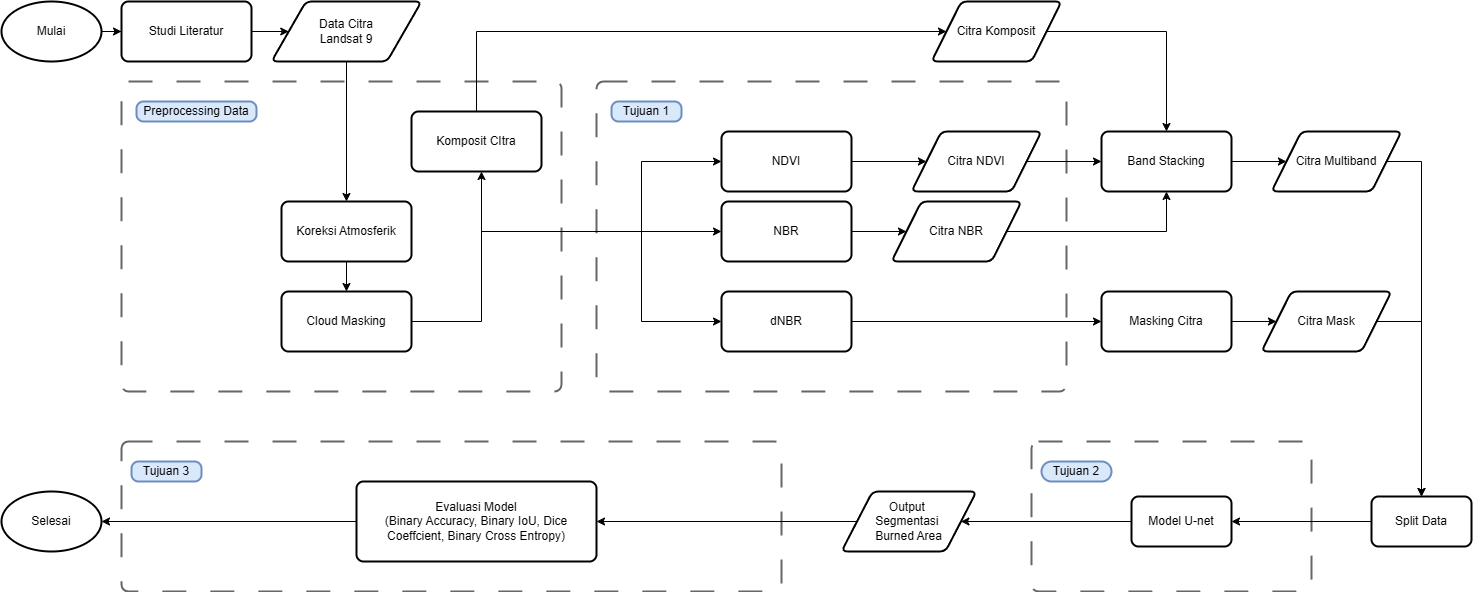

# **Preprocessing**


1.   DOS
2.   Cloud Masking
3.   Komposit Citra





```
path_row_list = [
    {'WRS_PATH': 124, 'WRS_ROW': 61},
    {'WRS_PATH': 124, 'WRS_ROW': 62},
    {'WRS_PATH': 125, 'WRS_ROW': 61},
    {'WRS_PATH': 125, 'WRS_ROW': 62}
]
```



Path Row cocok: 124 62 (kabupaten OKI, Ogan Ilir, Banyuasin)

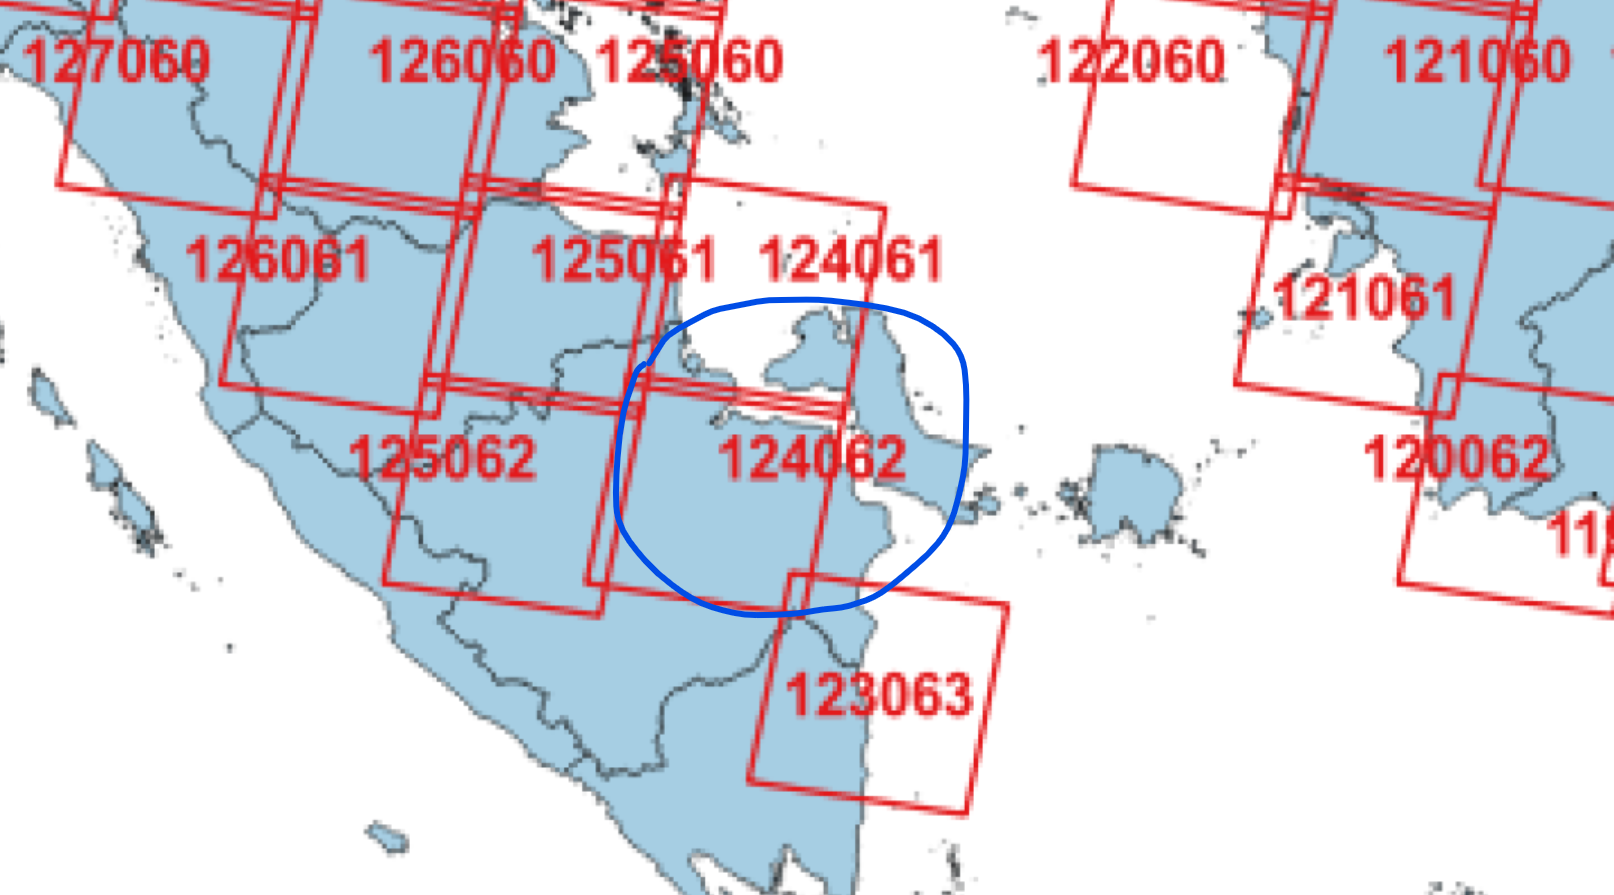

Path 124 62

In [2]:
import ee
import geemap

# Autentikasi dan inisialisasi Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-bigdata121450146')

# Daftar path/row (contoh: Sumatera Selatan)
path_row_list = [{'WRS_PATH': 124, 'WRS_ROW': 62}]

# Fungsi Cloud Masking pakai QA_PIXEL
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 4).eq(0))
    return image.updateMask(cloud_mask)

# Fungsi Dark Object Subtraction (DOS)
def apply_dos(image):
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    corrected = []

    for band in bands:
        band_data = image.select(band)
        stat = band_data.reduceRegion(
            reducer=ee.Reducer.percentile([1]),
            geometry=image.geometry(),
            scale=30,
            bestEffort=True,
            maxPixels=1e9
        )
        dark_object = stat.get(band)
        corrected_band = ee.Algorithms.If(
            dark_object,
            band_data.subtract(ee.Number(dark_object)).rename(band),
            band_data.rename(band)
        )
        corrected.append(ee.Image(corrected_band))

    return ee.Image.cat(corrected).copyProperties(image, image.propertyNames())

# Koleksi utama dengan masking awan


# filterDate('2023-01-01', '2023-12-31') \

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_TOA") \
    .filterDate('2023-08-01', '2023-09-30') \
    .filter(ee.Filter.Or(*[
        ee.Filter.And(
            ee.Filter.eq('WRS_PATH', item['WRS_PATH']),
            ee.Filter.eq('WRS_ROW', item['WRS_ROW'])
        ) for item in path_row_list
    ])) \
    .map(mask_clouds) \
    .map(apply_dos)

# Koleksi cadangan tanpa masking awan (tetap dengan koreksi DOS)
backup_collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_TOA") \
    .filterDate('2023-08-01', '2023-09-30') \
    .filter(ee.Filter.Or(*[
        ee.Filter.And(
            ee.Filter.eq('WRS_PATH', item['WRS_PATH']),
            ee.Filter.eq('WRS_ROW', item['WRS_ROW'])
        ) for item in path_row_list
    ])) \
    .map(apply_dos)

# Komposit median
composite_main = collection.median()
composite_backup = backup_collection.median()

# Gabungkan agar tidak berlubang
composite_filled = composite_main.unmask(composite_backup)

# Pilih band false color
false_color = composite_filled.select(['B7', 'B6', 'B4'])

# Tampilkan di peta
Map = geemap.Map()
Map.centerObject(collection.first(), zoom=8)
Map.addLayer(false_color, {
    'bands': ['B7', 'B6', 'B4'],
    'min': 0.0,
    'max': 0.4,
    'gamma': 1.3
}, 'False Color Composite (Filled)')
Map.addLayerControl()
Map


Map(center=[-2.895576944480676, 104.74870508429727], controls=(WidgetControl(options=['position', 'transparent…

# **NDVI & NBR**

# **dNBR (Masking Citra)**

# **Band Stacking**

# **Split Data**

# **Model U-Net**

# **Evaluasi Model**

## **Binary Accuracy**

## **Binary IoU**

## **Dice Coefficient**

## **Binary Cross Entropy (BCE)**

# *OPSIONAL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.9 MB/s eta 0:00:00



Jumlah band: 5
Ukuran citra: 7593 x 7773

Band 1:
  - Band Index : 1
  - Min        : nan
  - Max        : nan
  - Mean       : nan
  - Data type  : float32

Band 2:
  - Band Index : 2
  - Min        : nan
  - Max        : nan
  - Mean       : nan
  - Data type  : float32

Band 3:
  - Band Index : 3
  - Min        : nan
  - Max        : nan
  - Mean       : nan
  - Data type  : float32

Band 4:
  - Band Index : 4
  - Min        : nan
  - Max        : nan
  - Mean       : nan
  - Data type  : float32

Band 5:
  - Band Index : 5
  - Min        : nan
  - Max        : nan
  - Mean       : nan
  - Data type  : float32



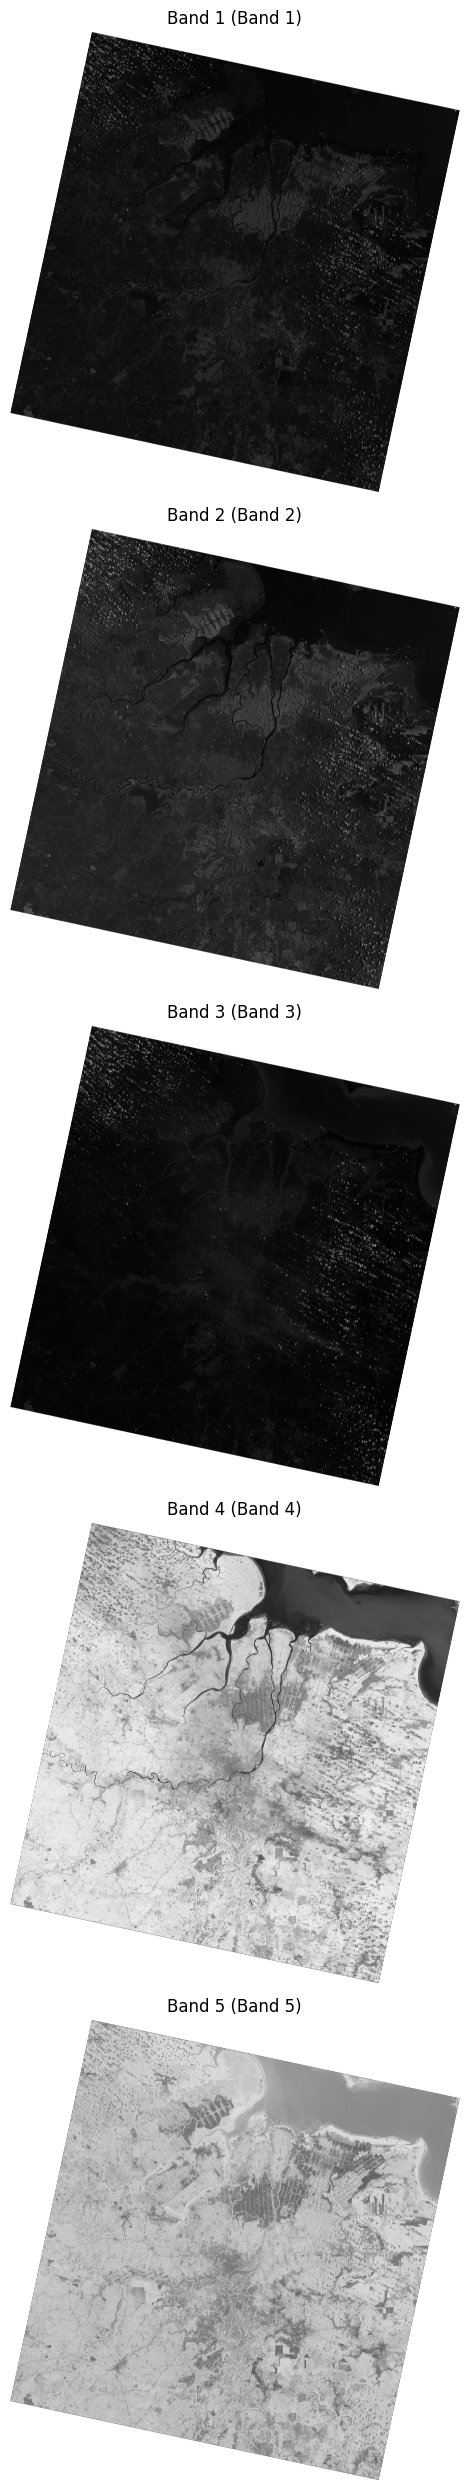

In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path ke file citra
file_path = '/content/drive/MyDrive/GEE_Exports/stacked_composite_ndvi_nbr.tif'

# Buka citra
with rasterio.open(file_path) as src:
    print(f"\nJumlah band: {src.count}")
    print(f"Ukuran citra: {src.width} x {src.height}\n")

    # Set ukuran plot
    plt.figure(figsize=(15, 5 * src.count))

    for i in range(1, src.count + 1):
        band = src.read(i)
        desc = src.descriptions[i - 1] if src.descriptions[i - 1] else f"Band {i}"
        min_val, max_val, mean_val = band.min(), band.max(), band.mean()

        # Info statistik band
        print(f"{desc}:")
        print(f"  - Band Index : {i}")
        print(f"  - Min        : {min_val:.2f}")
        print(f"  - Max        : {max_val:.2f}")
        print(f"  - Mean       : {mean_val:.2f}")
        print(f"  - Data type  : {band.dtype}\n")

        # Plot citra band
        plt.subplot(src.count, 1, i)
        plt.imshow(band, cmap='gray')
        plt.title(f'{desc} (Band {i})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



Jumlah band: 1
Ukuran citra: 7593 x 7773
Tipe data: float32
Min: nan, Max: nan, Mean: nan


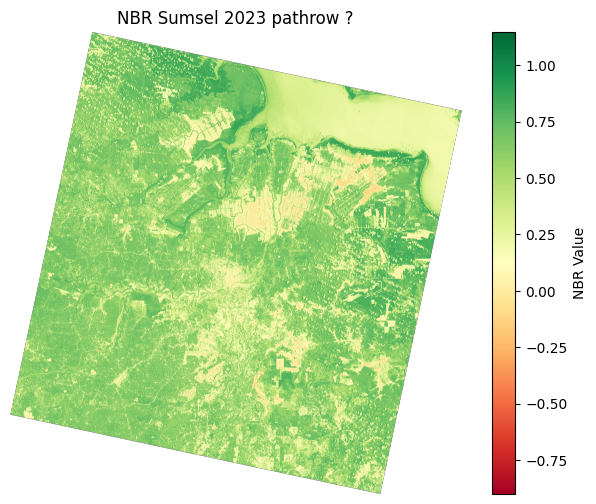

In [1]:
import rasterio
import matplotlib.pyplot as plt

# Path ke file 1-band
file_path = '/content/drive/MyDrive/GEE_Exports/NBR_Susmel_2023.tif'

# Buka citra
with rasterio.open(file_path) as src:
    print(f"Jumlah band: {src.count}")
    print(f"Ukuran citra: {src.width} x {src.height}")
    print(f"Tipe data: {src.dtypes[0]}")

    # Pastikan hanya 1 band
    if src.count == 1:
        band = src.read(1)
        print(f"Min: {band.min():.2f}, Max: {band.max():.2f}, Mean: {band.mean():.2f}")

        # Tampilkan citra
        plt.figure(figsize=(8, 6))
        plt.imshow(band, cmap='RdYlGn')
        plt.title('NBR Sumsel 2023 pathrow ?')
        plt.colorbar(label='NBR Value')
        plt.axis('off')
        plt.show()
    else:
        print("File ini memiliki lebih dari 1 band.")


Jumlah band: 1
Ukuran citra: 7593 x 7773
Tipe data: float32
Min: nan, Max: nan, Mean: nan


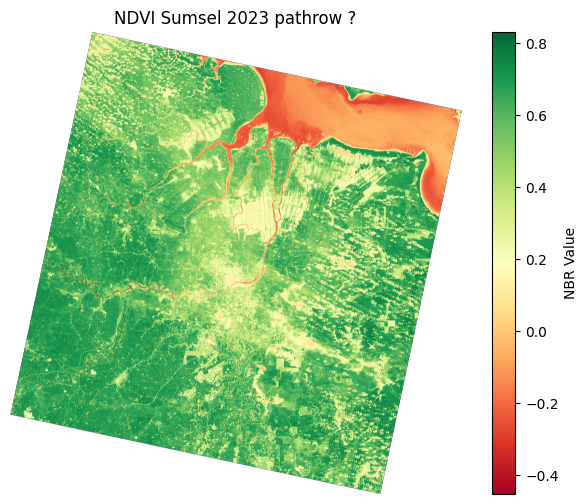

In [2]:
import rasterio
import matplotlib.pyplot as plt

# Path ke file 1-band
file_path = '/content/drive/MyDrive/GEE_Exports/NDVI_Susmel_2023.tif'

# Buka citra
with rasterio.open(file_path) as src:
    print(f"Jumlah band: {src.count}")
    print(f"Ukuran citra: {src.width} x {src.height}")
    print(f"Tipe data: {src.dtypes[0]}")

    # Pastikan hanya 1 band
    if src.count == 1:
        band = src.read(1)
        print(f"Min: {band.min():.2f}, Max: {band.max():.2f}, Mean: {band.mean():.2f}")

        # Tampilkan citra
        plt.figure(figsize=(8, 6))
        plt.imshow(band, cmap='RdYlGn')
        plt.title('NDVI Sumsel 2023 pathrow ?')
        plt.colorbar(label='NBR Value')
        plt.axis('off')
        plt.show()
    else:
        print("File ini memiliki lebih dari 1 band.")
